# Supporting Material: Acute Stroke Unit Model

Description/introduction of the notebook...

## Setup

In [47]:
import numpy as np
import pandas as pd
import random 
import itertools
import math
import matplotlib.pyplot as plt

In [48]:
import simpy
simpy.__version__

'4.1.1'

# 1.0 Utility functions

distribution classes used
- exponential for IAT (inter arrival time)
- lognormal for length of stay

## 1.1 Distribution classes

In [49]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

class Lognormal:
    """
    Encapsulates a lognormal distirbution
    """
    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean = mean of the lognormal distribution
        stdev = standard dev of the lognormal distribution
        """
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m = mean of lognormal distribution
        v = variance of lognormal distribution
                
        Returns:
        -------
        (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rand.lognormal(self.mu, self.sigma)

class Bernoulli:
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        p: float
            probability of drawing a 1
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.binomial(n=1, p=self.p, size=size)


## 1.2 Tracing function

In [50]:
def trace(msg):
    '''
    Utility function for printing simulation
    set the TRACE constant to FALSE to 
    turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

# 2.0 Model Setup
explain following code..

## 2.1 Model parameters

In [51]:
N_BEDS = 10 

# time between arrivals in days (exponential)
MEAN_IAT_STROKE = 1.2
MEAN_IAT_TIA = 9.3
MEAN_IAT_CN = 3.6
MEAN_IAT_OTHER = 3.2

# acute stroke unit length of stay in days (lognormal)
# acute stroke unit length of stay (lognormal distribution) for each patient type
STAY_PARAMS = {
    "Stroke": (7.4, 8.6),
    "Stroke_ESD": (4.6, 4.8), 
    "TIA": (1.8, 2.3),            
    "ComplexNeuro": (4.0, 5.0),   
    "Other": (3.8, 5.2)           
}
# transfer (bernoulli)
PROB_ESD = 0.1711

# SEEDS to reproduce results of a single run
REPRODUCIBLE_RUN = False

if REPRODUCIBLE_RUN:
    SEEDS = [42, 101, 1066, 1966, 2013, 999, 1444, 2016]
else:
    SEEDS = [None, None, None, None, None, None, None, None]

## 2.2 Scenerio class
Explain following code...

In [52]:
class Scenario:
    '''
    Parameter container class for acute stroke unit model.
    '''
    def __init__(self, 
                 iat_stroke = MEAN_IAT_STROKE,
                 iat_tia = MEAN_IAT_TIA,
                 iat_cn = MEAN_IAT_CN,
                 iat_other = MEAN_IAT_OTHER,
                 name=None):
        '''
        The init method sets up our defaults. 
        
        Params:
        -------
        
        name - str or None
            optional name for scenario
        '''
        
        # optional name
        self.name = name

        self.unit_beds = N_BEDS
        self.unit_beds_capacity = N_BEDS

        #store the parameters 
        self.iat_stroke = iat_stroke
        self.iat_tia = iat_tia
        self.iat_cn = iat_cn
        self.iat_other = iat_other

        #initialise results to zero
        self.init_results_variables()
        #Initialise patient arrival distribution
        self.init_sampling()
        self.patients = []

        # Initialize Length of Stay distributions for all patient types
        self.length_of_stay_dist = {
        patient_type: Lognormal(mean, std, random_seed=SEEDS[4])  
        for patient_type, (mean, std) in STAY_PARAMS.items()
        }

        # ESD transfer: prob that patient goes to ESD.
        self.esd_transfer = Bernoulli(PROB_ESD, random_seed=SEEDS[5])
        trace(f"ESD Transfer Probability: {PROB_ESD}")
   
    def init_sampling(self):
    # inter-arrival distribution for different patient types
        self.arrival_dist = {
            "Stroke": Exponential(MEAN_IAT_STROKE, random_seed=SEEDS[0]),
            "TIA": Exponential(MEAN_IAT_TIA, random_seed=SEEDS[1]),
            "ComplexNeuro": Exponential(MEAN_IAT_CN, random_seed=SEEDS[2]),
            "Other": Exponential(MEAN_IAT_OTHER, random_seed=SEEDS[3]),
        }

    def init_results_variables(self):
        self.results = {}
        self.results["n_stroke"] = 0
        self.results["n_tia"] = 0
        self.results["n_cn"] = 0
        self.results["n_other"] = 0
    
    def set_random_no_set(self, random_no_set):
        ''' Sets the random number seed for reproducibility '''
        np.random.seed(random_no_set)  # Set the random seed based on replication number
        # or any other logic you need for reproducibility

    def set_random_seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0, 2**32 - 1)
        np.random.seed(seed)
        # Re-initialize all random distributions with the new seed
        self.init_sampling()

# 3.0 Modelling the unit

summary of each section of code..


## 3.1 Modelling the Acute Stroke Unit

Arrival Generator per patient_type
Function which creates an arrival generator per patient type. Therefore, 4 functions for each patient entering the Acute Stroke Unit.

!!! Note to self: code redundancy can be fixed by creating one arrival generator but this is better to do after making sure the model runs properly.

In [53]:
class AcuteStrokeUnit:
    '''
    Model of an acute stroke unit
    '''
    def __init__(self, env, args):
        '''
        Constructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = env
        self.args = args 
        self.init_model_resources(args)
        self.args.total_bed_time_used = 0
        self.patients = []

        # Add a shared patient ID counter
        self.patient_id_counter = 0  

        # Start the arrival processes for different patient types
        env.process(self.stroke_arrivals_generator())
        env.process(self.tia_arrivals_generator())
        env.process(self.complexneuro_arrivals_generator())
        env.process(self.other_arrivals_generator())

    def init_model_resources(self, args):
        '''
        Setup the simpy resource objects
        
        Params:
        ------
        args - Scenario
            Simulation Parameter Container
        '''
        args.unit_beds = simpy.Resource(self.env, 
                                          capacity=args.unit_beds)
    def start_patient_arrivals(self):
        '''Start arrival processes for all patient types'''
        self.env.process(self.stroke_arrivals_generator())
        self.env.process(self.tia_arrivals_generator())
        self.env.process(self.complexneuro_arrivals_generator())
        self.env.process(self.other_arrivals_generator())

    def stroke_arrivals_generator(self):
        """Arrival process for stroke patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["Stroke"].sample()
            yield self.env.timeout(inter_arrival_time)
    
            # Increment global counter
            self.patient_id_counter += 1  
            new_patient = AcutePatient(self.patient_id_counter, self.env, self.args, patient_type="Stroke")
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())  # Metrics updated in assessment process
            trace(f'Patient {self.patient_id_counter} STROKE arrival at: {self.env.now:.3f}')

    def tia_arrivals_generator(self):
        """Arrival process for TIA patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["TIA"].sample()
            yield self.env.timeout(inter_arrival_time)
    
            self.patient_id_counter += 1  
            new_patient = AcutePatient(self.patient_id_counter, self.env, self.args, patient_type="TIA")
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())
    
            trace(f'Patient {self.patient_id_counter} TIA arrival at: {self.env.now:.3f}')

    def complexneuro_arrivals_generator(self):
        """Arrival process for ComplexNeuro patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["ComplexNeuro"].sample()
            yield self.env.timeout(inter_arrival_time)
    
            self.patient_id_counter += 1  
            new_patient = AcutePatient(self.patient_id_counter, self.env, self.args,patient_type="ComplexNeuro")
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())
    
            trace(f'Patient {self.patient_id_counter} ComplexNeuro arrival at: {self.env.now:.3f}')

    def other_arrivals_generator(self):
        """Arrival process for Other patients."""
        while True:
            inter_arrival_time = self.args.arrival_dist["Other"].sample()
            yield self.env.timeout(inter_arrival_time)
    
            self.patient_id_counter += 1  
            new_patient = AcutePatient(self.patient_id_counter, self.env, self.args,patient_type="Other")
            self.patients.append(new_patient)
            self.env.process(new_patient.assessment())
    
            trace(f'Patient {self.patient_id_counter} Other arrival at: {self.env.now:.3f}')


In [54]:
def calculate_bed_utilization(model):
    total_bed_time = sum(p.length_of_stay for p in model.patients if p.length_of_stay > 0)
    total_time = model.env.now * model.args.unit_beds_capacity # Access unit_beds_capacity from model.args
    utilization = total_bed_time / total_time
    print(f"Bed Utilization: {utilization * 100:.2f}%")

## 3.1 Modelling the patient

In [55]:
class AcutePatient:
    '''
    Patient in the minor ED process
    '''
    def __init__(self, identifier, env, args, patient_type):
        '''
        Constructor method
        '''
        self.identifier = identifier
        self.env = env
        self.args = args  # Store scenario parameters
        self.patient_type = patient_type  

        # Get length of stay distribution from Scenario
        self.length_of_stay_dist = args.length_of_stay_dist[patient_type]

        self.unit_beds = args.unit_beds 
        
        # ESD transfer probability
        self.esd_transfer = args.esd_transfer
        
        # Patient metrics
        self.time_to_bed = 0.0
        self.length_of_stay = 0.0
        self.time_to_esd = 0.0
        self.time_in_system = 0.0
    
    def assessment(self):
        '''Simulates the process for acute stroke unit'''
        arrival_time = self.env.now
        
        # Decide whether the patient will transfer to ESD
        raw_esd_decision = self.esd_transfer.sample()  # Get raw ESD decision (0 or 1)
        
        # Convert 0/1 to True/False for better readability in logs
        self.is_esd = self.patient_type == "Stroke" and raw_esd_decision == 1
        esd_final_decision = bool(self.is_esd)  # Convert to Boolean True/False
                
        with self.unit_beds.request() as req:
            yield req
            
            bed_time = self.env.now  
            trace(f'Patient {self.identifier} ({self.patient_type}) gets a bed at {self.env.now:.3f}')
            
            self.time_to_bed = self.env.now - arrival_time
        
            # ESD Transfer logic
            if self.is_esd:
                self.time_to_esd = self.env.now - bed_time
                length_of_stay = self.args.length_of_stay_dist["Stroke_ESD"].sample()
            else:
                length_of_stay = self.length_of_stay_dist.sample()
        
            yield self.env.timeout(length_of_stay)
        
            self.time_in_system = self.env.now - arrival_time
            self.length_of_stay = self.env.now - bed_time
            
            trace(f'Patient {self.identifier} discharged at {self.env.now:.3f}, '
                  f'LOS: {self.length_of_stay:.3f} days, Total time in system: {self.time_in_system:.3f} days')
        


## 3.2 Script to run the model 

In [56]:
# run length in minutes
RUN_LENGTH = 1445

# Define trace as on/off
#TRACE = False
TRACE = False

# create simpy environment
env = simpy.Environment()

# base case scenario with default parameters
default_args = Scenario()
# reset all results variables to zero and empty
default_args.init_results_variables()

# create the model
model = AcuteStrokeUnit(env, default_args)

# we pass all arrival generators to simpy 
env.process(model.stroke_arrivals_generator())  # Calling as a method of the model instance
env.process(model.tia_arrivals_generator())    # Calling as a method of the model instance
env.process(model.complexneuro_arrivals_generator())  # Calling as a method of the model instance
env.process(model.other_arrivals_generator())  # Calling as a method of the model instance



env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')
scenario = Scenario()  # Create an instance
print(scenario.results)  # Access and print the results dictionary
calculate_bed_utilization(model)


end of run. simulation clock time = 1445
{'n_stroke': 0, 'n_tia': 0, 'n_cn': 0, 'n_other': 0}
Bed Utilization: 99.02%


## Running metrics


In [57]:
# check between minutes and days 

In [58]:
discharged_patients = [p for p in model.patients if hasattr(p, 'length_of_stay') and p.length_of_stay > 0]

mean_length_of_stay = np.mean([p.length_of_stay for p in discharged_patients])

print(f"Mean Length of Stay: {mean_length_of_stay:.2f} days")


Mean Length of Stay: 5.39 days


In [59]:
## This needs 

In [60]:
# Ensure there are patients in the system
if model.patients:

    # Group patients by their type (e.g., "Stroke", "TIA", etc.)
    patient_types = set(p.patient_type for p in model.patients)  # Get unique patient types
    for patient_type in patient_types:
        # Filter patients by type
        patients_by_type = [p for p in model.patients if p.patient_type == patient_type]

        # 1. Mean time in system (from arrival to discharge)
        mean_time_in_system = np.mean([p.time_in_system for p in patients_by_type])

        # 2. Mean length of stay (from bed assignment to discharge)
        discharged_patients = [p for p in patients_by_type if hasattr(p, 'length_of_stay') and p.length_of_stay > 0]
        mean_length_of_stay = np.mean([p.length_of_stay for p in discharged_patients]) if discharged_patients else 0

        # 4. Mean time to bed (arrival → bed assignment)
        mean_time_to_bed = np.mean([p.time_to_bed for p in patients_by_type])

        # 5. Tracking ESD Transfers
        esd_patients = [p for p in patients_by_type if getattr(p, "is_esd", False)]  # Only Stroke ESD patients
        if esd_patients:
            # Debugging line to check the number of ESD patients
            print(f'Number of ESD patients: {len(esd_patients)}')  # This will print how many ESD patients there are
            
            # Calculate the mean length of stay for ESD patients (from bed assignment to discharge)
            esd_discharged_patients = [p for p in esd_patients if hasattr(p, 'length_of_stay') and p.length_of_stay > 0]
            mean_length_of_stay_esd = np.mean([p.length_of_stay for p in esd_discharged_patients]) if esd_discharged_patients else 0
            esd_transfer_rate = len(esd_patients) / len(patients_by_type)  # % of Stroke patients going to ESD
        else:
            mean_length_of_stay_esd = None
            esd_transfer_rate = 0
            print("No ESD patients found.")  # This will indicate if there are no ESD patients

        # Print results for this patient type
        print(f'\nResults for {patient_type} Patients\n------------------')
        print(f'Mean Time in System (days): {mean_time_in_system:.2f}')
        print(f'Mean Length of Stay (days): {mean_length_of_stay:.2f}')
        print(f'Mean Time to Bed (days): {mean_time_to_bed:.2f}')
        if esd_patients:
            print(f'Mean Length of Stay for ESD Patients (days): {mean_length_of_stay_esd:.2f}')
            print(f'Proportion of Patients Transferred to ESD: {esd_transfer_rate:.2%}')
        else:
            print("No ESD transfers for this patient type.")
        
else:
    print("No patients recorded in this simulation run.")


No ESD patients found.

Results for ComplexNeuro Patients
------------------
Mean Time in System (days): 179.07
Mean Length of Stay (days): 4.16
Mean Time to Bed (days): 177.90
No ESD transfers for this patient type.
No ESD patients found.

Results for TIA Patients
------------------
Mean Time in System (days): 157.28
Mean Length of Stay (days): 1.46
Mean Time to Bed (days): 156.45
No ESD transfers for this patient type.
Number of ESD patients: 399

Results for Stroke Patients
------------------
Mean Time in System (days): 169.38
Mean Length of Stay (days): 6.86
Mean Time to Bed (days): 167.26
Mean Length of Stay for ESD Patients (days): 4.85
Proportion of Patients Transferred to ESD: 16.71%
No ESD patients found.

Results for Other Patients
------------------
Mean Time in System (days): 168.55
Mean Length of Stay (days): 3.97
Mean Time to Bed (days): 166.20
No ESD transfers for this patient type.


In [61]:
def summarize_results(model):
    """ Generate a summary DataFrame with mean results for each patient type. """

    if not model.patients:
        print("⚠ No patients recorded in this simulation run.")
        return pd.DataFrame()  # Return an empty DataFrame

    patient_types = set(p.patient_type for p in model.patients)  # Unique patient types
    summary_data = {}

    # Calculate bed utilization
    total_bed_time = sum(p.length_of_stay for p in model.patients if p.length_of_stay > 0)
    total_time = model.env.now * scenario.unit_beds_capacity  # Access unit_beds_capacity from scenario
    bed_utilization = total_bed_time / total_time if total_time > 0 else np.nan
    summary_data["Bed Utilization (%)"] = bed_utilization * 100

    for patient_type in patient_types:
        patients_by_type = [p for p in model.patients if p.patient_type == patient_type]

        # Compute mean length of stay (only for patients with a valid length_of_stay)
        discharged_patients = [p for p in patients_by_type if hasattr(p, 'length_of_stay') and p.length_of_stay > 0]
        mean_length_of_stay = np.mean([p.length_of_stay for p in discharged_patients]) if discharged_patients else np.nan

        summary_data[patient_type] = mean_length_of_stay  # Store in dictionary

    # Convert dictionary to DataFrame with a single row
    return pd.DataFrame([summary_data])

TRACE = False 



In [62]:
def single_run(scenario, rc_period=1445):
    ''' Runs the model for a single scenario and returns results as a DataFrame. '''
    
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    env.run(until=rc_period)  # Run simulation

    return summarize_results(model)  # Return DataFrame with results

# Create the default scenario
args = Scenario()

# un the model
print('Running simulation ...', end=' => ')
results = single_run(args)
print('simulation complete.')

# Display the DataFrame
results


Running simulation ... => simulation complete.


,Bed Utilization (%),ComplexNeuro,TIA,Stroke,Other
0,99.716827,3.737902,1.839441,6.780533,3.90743


# Multiple Replications

In [63]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np

def multiple_replications(scenario, rc_period=1445, n_reps=150, n_jobs=-1):
    """
    Run multiple independent replications of the model and return results in a DataFrame.
    Each row represents a single replication, and columns represent patient types.
    """
    # Run multiple replications in parallel
    res = Parallel(n_jobs=n_jobs)(
        delayed(single_run)(Scenario()) for _ in range(n_reps) 
    )
    # Concatenate results, keeping each replication as a row
    df_results = pd.concat(res, keys=range(1, n_reps + 1), names=["rep"])
    
    # Reset index to have 'rep' as a column
    df_results.reset_index(level=0, inplace=True)

    return df_results.set_index("rep")  # Final format with replications as rows

# Run multiple replications
args = Scenario()
print("Running multiple replications ... => ", end="")
results = multiple_replications(args, rc_period=1445, n_reps=150, n_jobs=-1)
print("Simulation complete.")

# Display the results
results

Running multiple replications ... => Simulation complete.


,Bed Utilization (%),TIA,Other,ComplexNeuro,Stroke
rep,,,,,
1,99.245170,1.993947,3.841077,3.967130,6.999086
2,98.953987,1.718149,3.945623,4.412454,6.629327
3,99.405385,1.820842,3.991344,3.887867,6.845673
4,99.579418,1.750322,3.776692,4.122883,6.897770
5,99.166367,2.021082,3.989390,3.871433,7.029102
...,...,...,...,...,...
146,98.636235,1.751894,3.648256,3.890831,6.894038
147,99.257596,1.855677,3.460989,3.977459,6.689377
148,99.080707,1.708317,3.589321,4.048130,6.748052


In [64]:
results.mean()

Bed Utilization (%)    99.291631
TIA                     1.819995
Other                   3.797282
ComplexNeuro            3.959459
Stroke                  6.898092
dtype: float64

In [65]:
# tuesday 

In [66]:
# default scenario
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=5)
print('done.\n')

# show reps rounded to 2dp
results.round(2)

Running multiple replications => done.



,Bed Utilization (%),Stroke,Other,ComplexNeuro,TIA
rep,,,,,
1,99.26,7.12,3.56,3.83,1.89
2,99.64,6.81,3.63,4.01,1.72
3,99.12,6.81,3.35,3.85,1.85
4,99.36,6.70,3.91,4.15,1.76
5,99.42,6.74,4.33,4.26,1.74


In [67]:
# wait for bed

In [68]:
def summarize_results(model):
    """ Generate a summary DataFrame with mean results for each patient type. """

    if not model.patients:
        print("⚠ No patients recorded in this simulation run.")
        return pd.DataFrame()  # Return an empty DataFrame

    patient_types = set(p.patient_type for p in model.patients)  # Unique patient types
    summary_data = {}

    for patient_type in patient_types:
        patients_by_type = [p for p in model.patients if p.patient_type == patient_type]

        # Mean length of stay (only for patients with a valid length_of_stay)
        discharged_patients = [p for p in patients_by_type if hasattr(p, 'length_of_stay') and p.length_of_stay > 0]
        mean_length_of_stay = np.mean([p.length_of_stay for p in discharged_patients]) if discharged_patients else np.nan

        # Mean wait for bed (time from arrival to bed assignment)
        patients_with_bed = [p for p in patients_by_type if hasattr(p, 'time_to_bed') and p.time_to_bed > 0]
        mean_wait_for_bed = np.mean([p.time_to_bed for p in patients_with_bed]) if patients_with_bed else np.nan

        # Store results in dictionary
        summary_data[patient_type] = {
            "Mean Length of Stay (days)": mean_length_of_stay,
            "Mean Wait for Bed (days)": mean_wait_for_bed
        }

    # Convert dictionary to DataFrame
    return pd.DataFrame.from_dict(summary_data, orient="index")

TRACE = False 

def single_run(scenario, rc_period=1445):
    ''' Runs the model for a single scenario and returns results as a DataFrame. '''
    
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    env.run(until=rc_period)  # Run simulation

    return summarize_results(model)  # Return DataFrame with results

# Create the default scenario
args = Scenario()

# Run the model
print('Running simulation ...', end=' => ')
results = single_run(args)
print('simulation complete.')

# Display the DataFrame
results


Running simulation ... => simulation complete.


,Mean Length of Stay (days),Mean Wait for Bed (days)
ComplexNeuro,3.818984,304.530421
TIA,1.869240,308.345517
Stroke,6.825799,310.989956
Other,3.720027,320.204117


In [69]:
# Extract all 'time_in_system' values
time_in_system_values = [p.time_in_system for p in model.patients]

# Find the maximum time in system
max_time_in_system = max(time_in_system_values) if time_in_system_values else None

print(f"🔹 Longest time in system: {max_time_in_system:.3f} days")


🔹 Longest time in system: 660.127 days


In [70]:
scenario = Scenario()
samples = scenario.arrival_dist["Stroke"].sample(size=10000)  # Large sample
mean_sampled = np.mean(samples)

print(f"Expected Mean IAT: {MEAN_IAT_STROKE}")
print(f"Sampled Mean IAT: {mean_sampled}")


Expected Mean IAT: 1.2
Sampled Mean IAT: 1.2209923740840516


# Final replications

In [71]:
import pandas as pd
import numpy as np

def summarize_results(model):
    """ Generate a single-row DataFrame with mean results for each patient type. """

    if not model.patients:
        print("⚠ No patients recorded in this simulation run.")
        return pd.DataFrame()  # Return an empty DataFrame

    patient_types = ["Stroke", "TIA", "ComplexNeuro", "Other"]  # Fixed order
    summary_data = {}

    # Calculate bed utilization
    total_bed_time = sum(p.length_of_stay for p in model.patients if p.length_of_stay > 0)
    total_time = model.env.now * scenario.unit_beds_capacity  # Access unit_beds_capacity from scenario
    bed_utilization = (total_bed_time / total_time) * 100 if total_time > 0 else np.nan
    summary_data["Bed_Utilization (%)"] = bed_utilization

    for patient_type in patient_types:
        patients_by_type = [p for p in model.patients if p.patient_type == patient_type]

        # Mean wait for bed (time from arrival to bed assignment)
        patients_with_bed = [p for p in patients_by_type if hasattr(p, 'time_to_bed') and p.time_to_bed > 0]
        mean_wait_for_bed = np.mean([p.time_to_bed for p in patients_with_bed]) if patients_with_bed else np.nan

        # Store results with modified column names
        summary_data[f"{patient_type}_Wait"] = mean_wait_for_bed

    return pd.DataFrame([summary_data])  # Return as a single-row DataFrame

TRACE = False 

def single_run(scenario, rc_period=1445):
    ''' Runs the model for a single scenario and returns results as a DataFrame. '''
    
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    env.run(until=rc_period)  # Run simulation

    return summarize_results(model)  # Return DataFrame with results

# Create the default scenario
args = Scenario()

# Run the model
print('Running simulation ...', end=' => ')
results = single_run(args)
print('simulation complete.')

# Display the DataFrame
results


Running simulation ... => simulation complete.


,Bed_Utilization (%),Stroke_Wait,TIA_Wait,ComplexNeuro_Wait,Other_Wait
0,99.402282,288.791976,272.099259,286.95891,288.001505


In [72]:
def multiple_replications(scenario, rc_period=1445, n_reps=150, n_jobs=-1):
    """
    Run multiple independent replications of the model and return results in a DataFrame.
    Each row represents a single replication, and columns represent patient types.
    """
    # Run multiple replications in parallel
    res = Parallel(n_jobs=n_jobs)(
        delayed(single_run)(Scenario()) for _ in range(n_reps) 
    )
    # Concatenate results, keeping each replication as a row
    df_results = pd.concat(res, keys=range(1, n_reps + 1), names=["rep"])
    
    # Reset index to have 'rep' as a column
    df_results.reset_index(level=0, inplace=True)

    return df_results.set_index("rep")  # Final format with replications as rows

# Run multiple replications
args = Scenario()
print("Running multiple replications ... => ", end="")
results = multiple_replications(args, rc_period=1445, n_reps=150, n_jobs=-1)
print("Simulation complete.")

# Display the results
results

Running multiple replications ... => Simulation complete.


,Bed_Utilization (%),Stroke_Wait,TIA_Wait,ComplexNeuro_Wait,Other_Wait
rep,,,,,
1,99.229628,321.405463,315.887576,319.481154,323.492447
2,99.308405,265.576569,273.779889,268.791371,264.124668
3,99.218540,289.929184,290.210898,302.231332,270.706981
4,99.487467,276.433233,277.986513,290.726785,267.767862
5,99.234029,263.402402,256.299975,248.992386,253.837316
...,...,...,...,...,...
146,98.748819,324.249117,333.961148,319.996484,324.062840
147,99.287022,282.749377,283.747418,282.253649,286.191257
148,99.468345,297.028244,278.125802,296.776969,301.238565


In [73]:
results.mean()

Bed_Utilization (%)     99.318485
Stroke_Wait            282.293783
TIA_Wait               283.483355
ComplexNeuro_Wait      282.085185
Other_Wait             280.891061
dtype: float64

Running multiple replications => done.



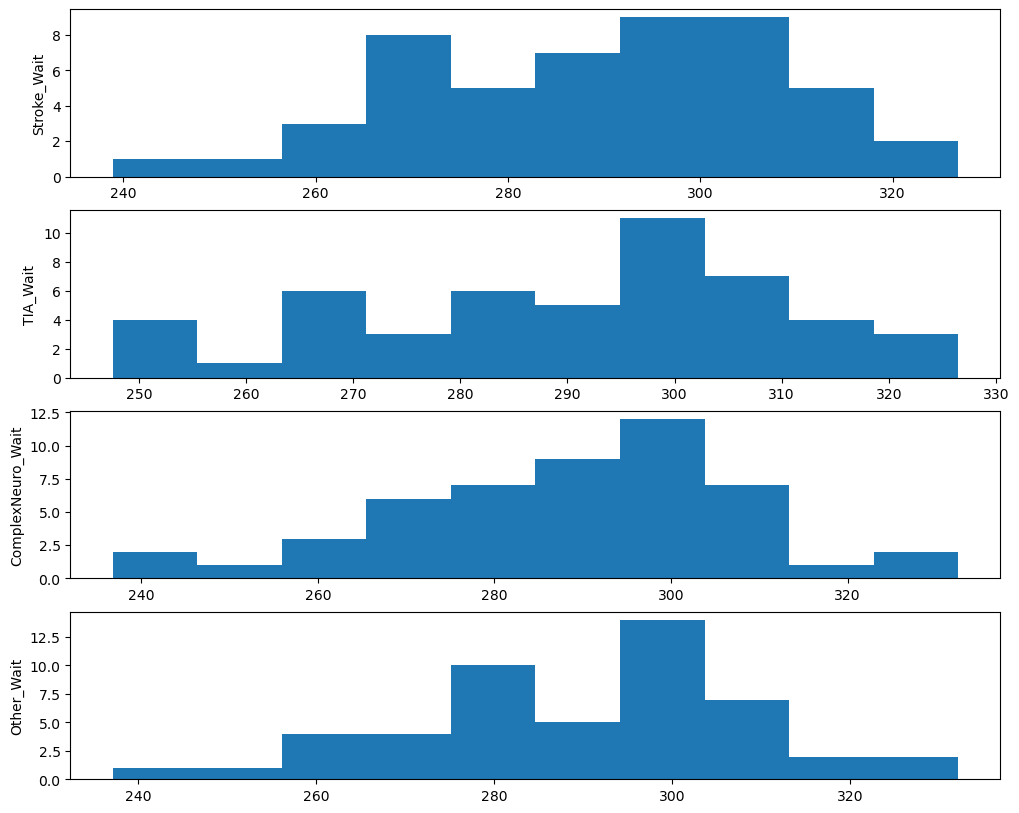

In [74]:
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=50)
print('done.\n')

fig, ax = plt.subplots(4, 1, figsize=(12,10))
ax[0].hist(results['Stroke_Wait']);
ax[0].set_ylabel('Stroke_Wait')
ax[1].hist(results['TIA_Wait']);
ax[1].set_ylabel('TIA_Wait');
ax[2].hist(results['ComplexNeuro_Wait']);
ax[2].set_ylabel('ComplexNeuro_Wait');
ax[3].hist(results['Other_Wait']);
ax[3].set_ylabel('Other_Wait');

In [75]:
# warm up

In [76]:
import itertools
import pandas as pd

DEFAULT_WARMUP_AUDIT_INTERVAL = 60  # Example value in days

class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. Bed utilisation
    2. Mean wait time for each patient group
    '''
    def __init__(self, model, scenario, interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        self.env = model.env
        self.model = model
        self.scenario = scenario
        self.interval = interval
        self.bed_utilization = []  # Store bed utilization over time
        self.stroke_wait = []
        self.tia_wait = []
        self.complexneuro_wait = []
        self.other_wait = []

    def run(self, rc_period):
        '''
        Run the audited model
        
        Parameters:
        ----------
        rc_period: float
            Results collection period. Should be long enough to allow meaningful data collection.
            
        Returns:
        -------
        None.
        '''
        # Start periodic auditing
        self.env.process(self.audit_model())
        self.env.run(until=rc_period)

    def audit_model(self):
        '''
        Audit the model at the specified intervals.
        '''
        for i in itertools.count():
            yield self.env.timeout(self.interval)
            
            # ✅ Compute Bed Utilization
            total_bed_time = sum(p.length_of_stay for p in self.model.patients if p.length_of_stay > 0)
            total_time = self.env.now * self.scenario.unit_beds_capacity  # Get from scenario
            bed_util = (total_bed_time / total_time) * 100 if total_time > 0 else 0

            #✅ Compute Mean Wait Time for Each Patient Type
            patient_types = ["Stroke", "TIA", "ComplexNeuro", "Other"]
            wait_times = {}
            for p_type in patient_types:
                patients = [p for p in self.model.patients if p.patient_type == p_type]
                valid_patients = [p.time_to_bed for p in patients if hasattr(p, 'time_to_bed') and p.time_to_bed > 0]
                wait_time = np.mean(valid_patients) if valid_patients else 0
                wait_times[p_type.lower() + '_wait'] = wait_time
                
            # ✅ Store Metrics
            self.bed_utilization.append(bed_util)
            self.stroke_wait.append(wait_times['stroke_wait'])
            self.tia_wait.append(wait_times['tia_wait'])
            self.complexneuro_wait.append(wait_times['complexneuro_wait'])
            self.other_wait.append(wait_times['other_wait'])

    def summary_frame(self):
        '''
        Return the audit observations in a summary dataframe.
        
        Returns:
        -------
        pd.DataFrame
        '''
        df = pd.DataFrame({
            'bed_util': self.bed_utilization,
            'stroke_wait': self.stroke_wait,
            'tia_wait': self.tia_wait,
            'complexneuro_wait': self.complexneuro_wait,
            'other_wait': self.other_wait
        })

        return df


In [87]:
# time series 
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

def warmup_single_run(scenario, rc_period, interval=60, rep_id=0):
    """
    Perform a single warm-up run and return a DataFrame with results.
    """
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    data = []
    for t in range(0, rc_period, interval):
        env.run(until=t + interval)  # Run simulation until the next interval
        bed_util = calculate_bed_utilization(model)
        wait_times = {
            "Stroke_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "Stroke" and hasattr(p, 'time_to_bed')]),
            "TIA_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "TIA" and hasattr(p, 'time_to_bed')]),
            "ComplexNeuro_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "ComplexNeuro" and hasattr(p, 'time_to_bed')]),
            "Other_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "Other" and hasattr(p, 'time_to_bed')])
        }
        data.append({"time": t + interval, "Bed_Utilization": bed_util, **wait_times})

    df = pd.DataFrame(data)
    df["rep"] = f"rep_{rep_id + 1}"  # Label replications as rep_1, rep_2, etc.
    return df

def warmup_analysis(scenario, rc_period, n_reps=10, interval=60, n_jobs=-1):
    """
    Runs multiple replications of the warm-up analysis in parallel.
    """
    res = Parallel(n_jobs=n_jobs)(
        delayed(warmup_single_run)(scenario, rc_period, interval, rep_id) for rep_id in range(n_reps)
    )

    # Combine results into a single DataFrame
    df_warmup = pd.concat(res, ignore_index=True)

    # Reshape so that each replication is a separate column for a specific metric
    df_pivot = df_warmup.pivot(index="time", columns="rep", values="Bed_Utilization")  # Change metric if needed

    return df_warmup, df_pivot

# Run and test
RUN_LENGTH = 1827
N_REPS = 10
scenario = Scenario()

print("Running warm-up analysis with replications. Please wait...", end=" => ")
df_warmup, df_pivot = warmup_analysis(scenario, rc_period=RUN_LENGTH, n_reps=N_REPS)
print("done.")

# Display first few rows of both DataFrames
print("Warm-up DataFrame:")
print(df_warmup.head())

print("\nPivoted DataFrame:")
df_pivot.head()


Running warm-up analysis with replications. Please wait... => done.
Warm-up DataFrame:
   time  Bed_Utilization  Stroke_Wait   TIA_Wait  ComplexNeuro_Wait  \
0    60        79.608879     7.053307   7.378455           5.603405   
1   120        90.255053    14.848359  16.917671          16.182579   
2   180        96.059208    19.097048  23.243138          23.545657   
3   240        95.541123    29.604100  26.752928          29.304829   
4   300        97.007362    38.792273  34.710644          35.772079   

   Other_Wait    rep  
0    6.211588  rep_1  
1   13.151432  rep_1  
2   20.085024  rep_1  
3   26.856276  rep_1  
4   32.970370  rep_1  

Pivoted DataFrame:


rep,rep_1,rep_10,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9
time,,,,,,,,,,
60,79.608879,79.608879,79.608879,79.608879,79.608879,79.608879,79.608879,79.608879,79.608879,79.608879
120,90.255053,90.255053,90.255053,90.255053,90.255053,90.255053,90.255053,90.255053,90.255053,90.255053
180,96.059208,96.059208,96.059208,96.059208,96.059208,96.059208,96.059208,96.059208,96.059208,96.059208
240,95.541123,95.541123,95.541123,95.541123,95.541123,95.541123,95.541123,95.541123,95.541123,95.541123
300,97.007362,97.007362,97.007362,97.007362,97.007362,97.007362,97.007362,97.007362,97.007362,97.007362


Running warm-up analysis with replications. Please wait... => done.


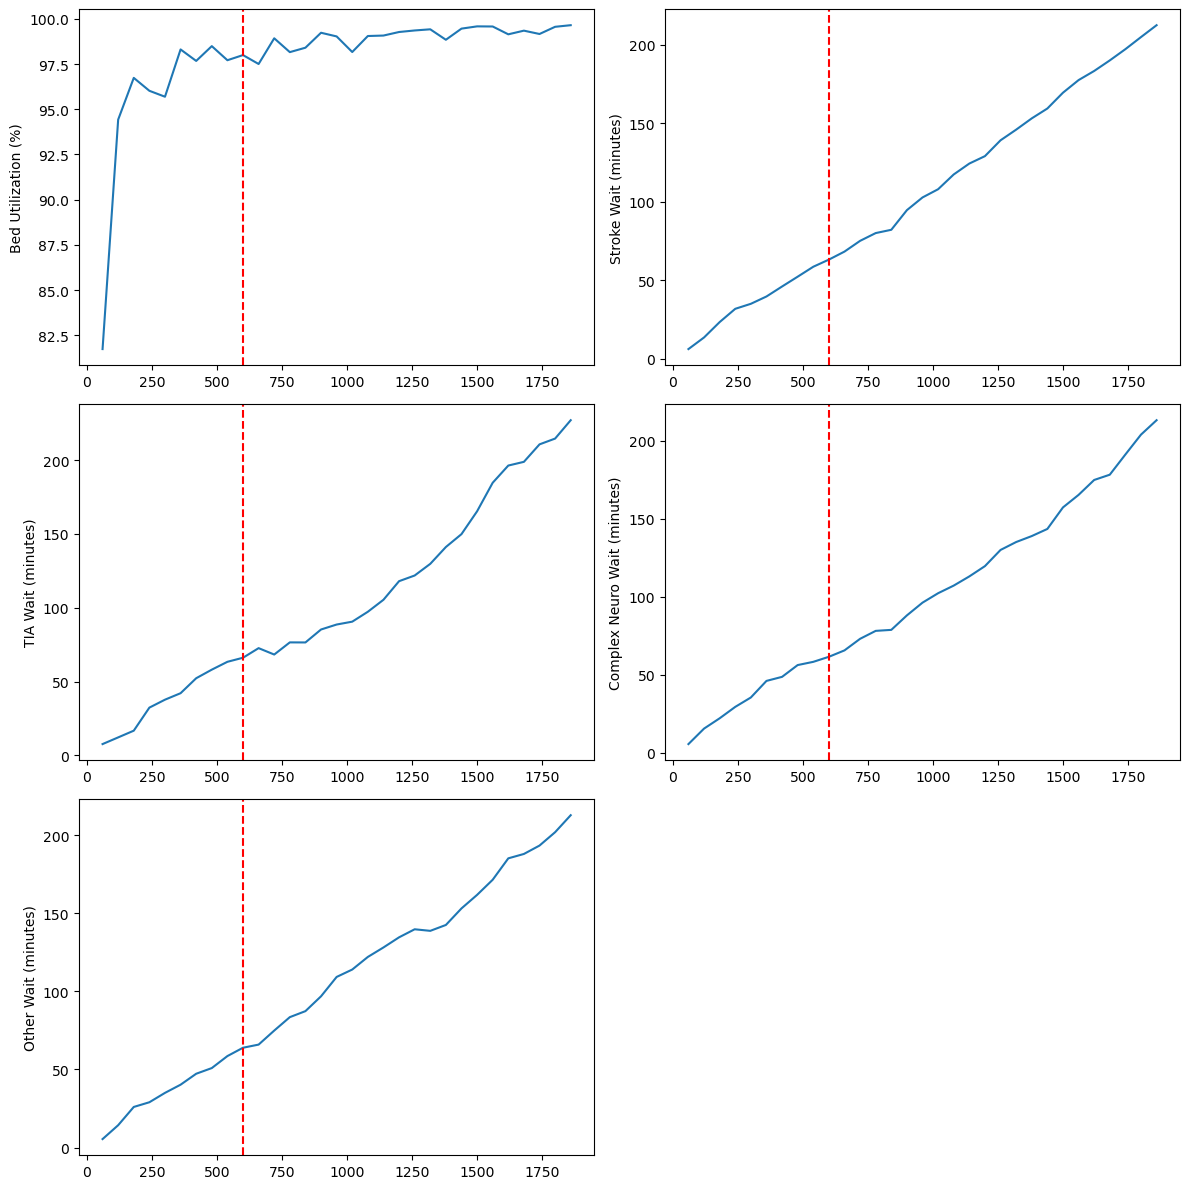

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def warmup_single_run(scenario, rc_period, interval=60, rep_id=0):
    """
    Perform a single warm-up run and return a DataFrame with results.
    """
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)

    # Start patient arrival processes
    env.process(model.stroke_arrivals_generator())
    env.process(model.tia_arrivals_generator())
    env.process(model.complexneuro_arrivals_generator())
    env.process(model.other_arrivals_generator())

    data = []
    for t in range(0, rc_period, interval):
        env.run(until=t + interval)  # Run simulation until the next interval
        bed_util = calculate_bed_utilization(model)
        wait_times = {
            "Stroke_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "Stroke" and hasattr(p, 'time_to_bed')]),
            "TIA_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "TIA" and hasattr(p, 'time_to_bed')]),
            "ComplexNeuro_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "ComplexNeuro" and hasattr(p, 'time_to_bed')]),
            "Other_Wait": np.mean([p.time_to_bed for p in model.patients if p.patient_type == "Other" and hasattr(p, 'time_to_bed')])
        }
        data.append({"time": t + interval, "Bed_Utilization": bed_util, **wait_times})

    df = pd.DataFrame(data)
    df["rep"] = f"rep_{rep_id + 1}"  # Label replications as rep_1, rep_2, etc.
    return df

def warmup_analysis(scenario, rc_period, n_reps=10, interval=60, n_jobs=-1):
    """
    Runs multiple replications of the warm-up analysis in parallel.
    Returns a dictionary of results for different performance metrics.
    """
    res = Parallel(n_jobs=n_jobs)(
        delayed(warmup_single_run)(scenario, rc_period, interval, rep_id) for rep_id in range(n_reps)
    )

    # Combine all results into a single DataFrame
    df_warmup = pd.concat(res, ignore_index=True)

    # Define metrics available in your results
    metrics = ["Bed_Utilization", "Stroke_Wait", "TIA_Wait", "ComplexNeuro_Wait", "Other_Wait"]

    # Create a dictionary where each key is a metric and the value is a pivoted DataFrame
    results = {
        metric: df_warmup.pivot(index="time", columns="rep", values=metric)
        for metric in metrics
    }

    return results

def time_series_inspection(results, warm_up=None):
    """
    Time series inspection method.
    
    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis.
    
    warm_up: int or None
        The warm-up period to display on the graphs (optional).
    
    Returns:
    -------
    fig: matplotlib.figure.Figure
        The figure object containing the plots.
        
    ax: numpy.ndarray of matplotlib.axes._axes.Axes
        The axes objects containing the individual plots.
    """
    
    # Create the 5 chart areas to plot (4 wait times + 1 bed utilization)
    fig, ax = plt.subplots(3, 2, figsize=(12, 12))
    ax = ax.flatten()  # Flatten the 2D array of axes

    # Plot each metric
    ax[0].plot(results['Bed_Utilization'].mean(axis=1))
    ax[1].plot(results['Stroke_Wait'].mean(axis=1))
    ax[2].plot(results['TIA_Wait'].mean(axis=1))
    ax[3].plot(results['ComplexNeuro_Wait'].mean(axis=1))
    ax[4].plot(results['Other_Wait'].mean(axis=1))

    # Set the label of each chart
    ax[0].set_ylabel('Bed Utilization (%)')
    ax[1].set_ylabel('Stroke Wait (minutes)')
    ax[2].set_ylabel('TIA Wait (minutes)')
    ax[3].set_ylabel('Complex Neuro Wait (minutes)')
    ax[4].set_ylabel('Other Wait (minutes)')

    if warm_up is not None:
        # Add warm-up cut-off vertical line if one is specified
        for i in range(5):
            ax[i].axvline(x=warm_up, color='red', ls='--')

    # Remove empty subplot if it exists
    if len(ax) > 5:
        fig.delaxes(ax[5])

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    return fig, ax

# Run and test
RUN_LENGTH = 1827
N_REPS = 10
scenario = Scenario()

print("Running warm-up analysis with replications. Please wait...", end=" => ")
results = warmup_analysis(scenario, rc_period=RUN_LENGTH, n_reps=N_REPS)
print("done.")

# Call time series inspection to plot graphs including Bed Utilization
fig, ax = time_series_inspection(results, warm_up=600)
plt.show()


## Rerunning the model with warm up time

In [79]:
# THIS IS AS FAR AS I GOT 
#EVERYTHING BELOW HERE NEEDS CHANGING 
# I think the warm up period is 600 - THATS WHEN UTILISATION STABALISES 

############## MODIFICATION  ################################
# Set model's warmup period
AUDIT_INTERVAL = 120
WARM_UP_INTERVALS = 600
WARM_UP = WARM_UP_INTERVALS * AUDIT_INTERVAL  # Convert to minutes
##############################################################

# Results collection over a single day
RC_PERIOD = 1440

# Number of replications
N_REPS = 80

# Default scenario
args = Scenario()

# Run multiple replications (without warm_up)
print('Running multiple replications', end=' => ')
replications = multiple_replications(args, rc_period=RC_PERIOD, n_reps=N_REPS)
print('done.\n')

# Show results summary rounded to 2 decimal places
replications.describe().round(2)


Running multiple replications => done.



,Bed_Utilization (%),Stroke_Wait,TIA_Wait,ComplexNeuro_Wait,Other_Wait
count,80.00,80.00,80.00,80.00,80.00
mean,99.34,279.17,281.94,279.96,278.96
std,0.24,21.87,22.31,22.55,22.97
min,98.62,219.00,227.04,219.60,219.05
25%,99.17,265.28,266.19,264.08,265.66
50%,99.36,278.90,278.35,280.54,277.22
75%,99.54,294.26,297.02,292.96,293.67
max,99.70,338.76,337.85,332.34,348.45


# Selecting the number of replications to run

## Confidence Interval 

Finds the smallest number of replications where the width of the confidence
    interval is less than the desired_precision.  
    
    Returns both the number of replications and the full results dataframe.

In [80]:
from scipy.stats import t
def confidence_interval_method(replications, alpha=0.05, desired_precision=0.05, 
                               min_rep=5, decimal_place=2):
    '''
    Determines the required number of replications based on confidence intervals.

    Parameters:
    ----------
    replications: array-like
        Array of replications of a performance metric.
        
    alpha: float, optional (default=0.05)
        Confidence level for the interval.
        
    desired_precision: float, optional (default=0.05)
        Target mean deviation from the confidence interval.
        
    min_rep: int, optional (default=5)
        Minimum number of replications before applying precision target.
        
    decimal_places: int, optional (default=2)
        Rounds the results to specified decimal places.
    
    Returns:
    --------
        tuple: (int, pd.DataFrame)
    '''
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]

    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        # Running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    # Unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    # Half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2), dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
        
    half_width = t_value * std_error
        
    # Upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    # Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    # Combine results into a single DataFrame
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    
    # Get the smallest no. of reps where deviation is less than precision target
    try:
        n_reps = results.iloc[min_rep:].loc[results['% deviation'] 
                             <= desired_precision*100].iloc[0].name
    except:
        warnings.warn('WARNING: The replications do not reach desired precision')
        n_reps = -1 

    return n_reps, results.round(decimal_place)

############## APPLY CONFIDENCE INTERVAL METHOD ################################
############## APPLY CONFIDENCE INTERVAL METHOD ################################
# Extract the mean wait times across replications for 'Stroke_Wait'
stroke_wait_means = replications["Stroke_Wait"].dropna().values  # 🔥 Fixed

# Run confidence interval analysis
n_reps, ci_results = confidence_interval_method(stroke_wait_means)

# Display results
print(f"Recommended number of replications: {n_reps}")
print(ci_results.head())



Recommended number of replications: 17
                Mean  Cumulative Mean  Standard Deviation  Lower Interval  \
replications                                                                
1             262.06           262.06                 NaN             NaN   
2             228.37           245.22               23.82          211.69   
3             316.45           268.96               44.44          217.89   
4             304.30           277.80               40.36          237.63   
5             290.58           280.35               35.42          248.83   

              Upper Interval  % deviation  
replications                               
1                        NaN          NaN  
2                     278.74        13.67  
3                     320.03        18.99  
4                     317.96        14.46  
5                     311.88        11.25  


In [81]:
ci_results.head()

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,262.06,262.06,NaN,NaN,NaN,NaN
2,228.37,245.22,23.82,211.69,278.74,13.67
3,316.45,268.96,44.44,217.89,320.03,18.99
4,304.30,277.80,40.36,237.63,317.96,14.46
5,290.58,280.35,35.42,248.83,311.88,11.25


In [82]:
def plot_confidence_interval_method(n_reps, conf_ints, metric_name, 
                                    figsize=(12,4)):
    '''
    Plot the confidence intervals and cumulative mean
    
    Parameters:
    ----------
    n_reps: int
        minimum number of reps selected
        
    conf_ints: pandas.DataFrame
       results of the `confidence_interval_method` function
       
    metric_name: str
        Name of the performance measure
        
    figsize: tuple, optional (default=(12,4))
        The size of the plot
        
    Returns:
    -------
        matplotlib.pyplot.axis
    '''
    # plot cumulative mean + lower/upper intervals
    ax = conf_ints[['Cumulative Mean', 'Lower Interval', 
                         'Upper Interval']].plot(figsize=figsize)
    # add the 
    ax.axvline(x=n_reps, ls='--', color='red')
    
    ax.set_ylabel(f'cumulative mean: {metric_name}')
    
    return ax

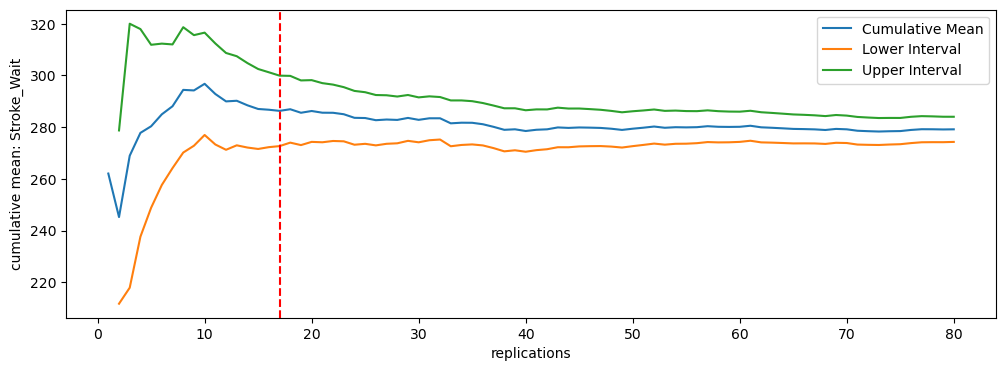

In [83]:
# Plot the confidence intervals (FIXED: Using ci_results instead of conf_ints)
ax = plot_confidence_interval_method(n_reps, ci_results, metric_name='Stroke_Wait')


In [84]:
# Define lookahead range (15 replications after n_reps)
lookahead = 15

# ✅ FIXED: Use ci_results instead of conf_ints
ci_results.iloc[n_reps-1 : n_reps+lookahead]


,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
17,279.13,286.31,28.24,272.67,299.94,4.76
18,297.69,286.94,27.53,274.02,299.85,4.50
19,261.18,285.58,27.40,273.07,298.09,4.38
20,299.08,286.26,26.84,274.31,298.20,4.17
21,272.41,285.60,26.33,274.16,297.04,4.00
22,284.93,285.57,25.70,274.66,296.47,3.82
23,272.79,285.01,25.25,274.53,295.49,3.68
24,251.54,283.62,25.62,273.21,294.03,3.67
25,281.71,283.54,25.08,273.56,293.53,3.52



Minimum number of reps for 5% precision: 37



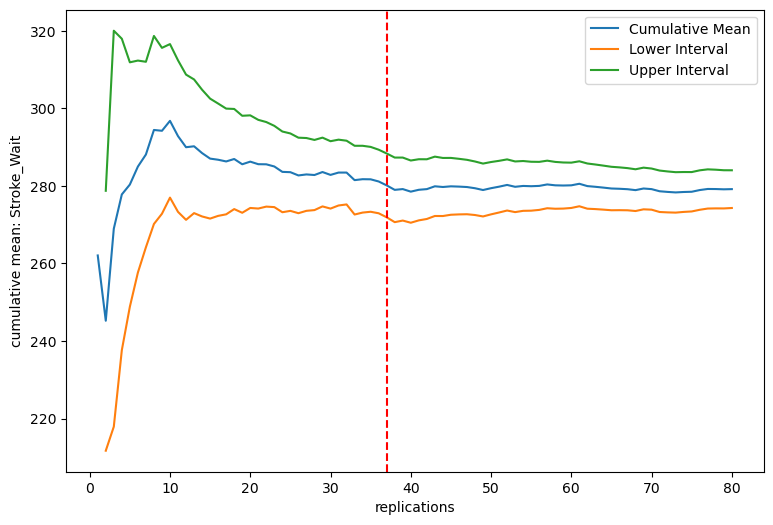

In [85]:
# Run the confidence interval method on 'Stroke_Wait' replications
n_reps, conf_ints = confidence_interval_method(
    replications['Stroke_Wait'].to_numpy(),  # Use an existing metric
    desired_precision=0.05, 
    min_rep=36
)

# Print the minimum number of replications needed
print(f'\nMinimum number of reps for 5% precision: {n_reps}\n')

# Plot the confidence intervals
ax = plot_confidence_interval_method(n_reps, conf_ints, 
                                     metric_name='Stroke_Wait', figsize=(9,6))


# Scenarios analysis

Scenario: beds_10, Bed Utilization: 100.00%
Scenario: beds_20, Bed Utilization: 100.00%
Scenario: beds_30, Bed Utilization: 76.72%
Scenario: beds_40, Bed Utilization: 57.45%


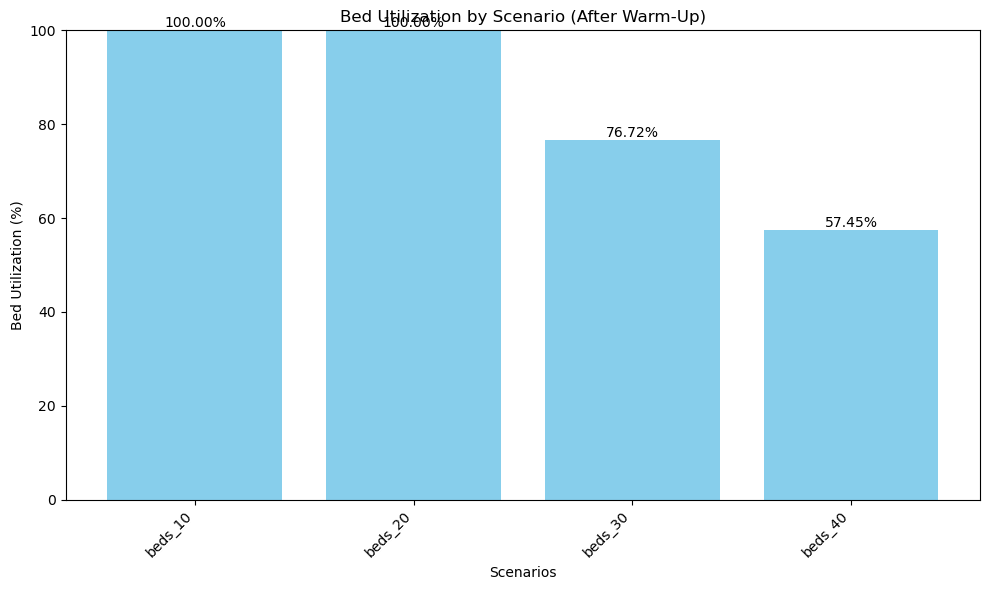

In [90]:
import matplotlib.pyplot as plt
 
# Constants for warm-up and results collection
AUDIT_INTERVAL = 1  # Minutes per audit interval
WARM_UP_INTERVALS = 600  # Number of intervals for warm-up
WARM_UP = WARM_UP_INTERVALS * AUDIT_INTERVAL  # Warm-up period in minutes
RC_PERIOD = 1440  # Results collection period (1 day in minutes)
 
def calculate_bed_utilization(model, start_time):
    """Calculate bed utilization after the warm-up period, capped at 100%."""
    total_bed_time = sum(min(p.length_of_stay, model.env.now - start_time) 
                         for p in model.patients 
                         if p.length_of_stay > 0 and (model.env.now - p.time_to_bed) >= start_time)
    total_time = (model.env.now - start_time) * model.args.unit_beds_capacity
    utilization = (total_bed_time / total_time) * 100 if total_time > 0 else 0
    return min(utilization, 100)  # Cap at 100%
 
 
def run_simulation(scenario):
    """Runs a single simulation with a given scenario and returns bed utilization."""
    env = simpy.Environment()
    model = AcuteStrokeUnit(env, scenario)
 
    # Start the arrival processes
    model.start_patient_arrivals()
 
    # Run the simulation for warm-up + results collection period
    env.run(until=WARM_UP + RC_PERIOD)
 
    # Calculate bed utilization only for the results collection period after warm-up
    bed_utilization = calculate_bed_utilization(model, WARM_UP)
    return bed_utilization
 
# Create scenarios
def get_scenarios():
    """Returns a dictionary of scenarios with different bed counts."""
    scenarios = {}
    bed_counts = [10, 20, 30, 40]  # Example bed counts
    for bed_count in bed_counts:
        scenario = Scenario()
        scenario.unit_beds = bed_count
        scenario.unit_beds_capacity = bed_count
        scenarios[f'beds_{bed_count}'] = scenario
    return scenarios
 
scenarios = get_scenarios()
 
# Store results
results = {}
 
# Run simulations for each scenario and store results
for scenario_name, scenario in scenarios.items():
    bed_utilization = run_simulation(scenario)
    results[scenario_name] = bed_utilization
    print(f"Scenario: {scenario_name}, Bed Utilization: {bed_utilization:.2f}%")
 
# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title('Bed Utilization by Scenario (After Warm-Up)')
plt.xlabel('Scenarios')
plt.ylabel('Bed Utilization (%)')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%
 
# Add value labels on top of each bar
for i, (scenario, utilization) in enumerate(results.items()):
    plt.text(i, utilization, f'{utilization:.2f}%', ha='center', va='bottom')
 
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
 
# Adjust layout and display the chart
plt.tight_layout()
plt.show()